<a href="https://colab.research.google.com/github/Bertaalcolea/Collagen_studies/blob/main/Concentraciones_Rat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import files

uploaded = files.upload()
file = list(uploaded.keys())[0]
file


Saving Concentration_study_1.xlsx to Concentration_study_1.xlsx


'Concentration_study_1.xlsx'

In [3]:
# Leemos la primera hoja (Plate 1 - Sheet1)
df = pd.read_excel(file, sheet_name=0, header=None)

# Filas que contienen "350 - Time"
time_rows = df[
    df.apply(lambda r: r.astype(str).str.contains("350 - Time").any(), axis=1)
].index

len(time_rows), time_rows[:10]


(121, Index([36, 50, 62, 74, 86, 98, 110, 122, 134, 146], dtype='int64'))

In [4]:
def to_float(x):
    """Convierte a float si puede; si no, NaN."""
    if isinstance(x, (int, float)):
        return float(x)
    if isinstance(x, str):
        s = x.replace(",", ".").strip()
        try:
            return float(s)
        except:
            return np.nan
    return np.nan

def parse_time_min(cell):
    """
    cell: string tipo '350 - Time 1 (0:00:12)'
    devuelve tiempo en minutos (float)
    """
    s = str(cell)
    if "(" not in s or ")" not in s:
        return np.nan
    inside = s.split("(")[1].split(")")[0]   # '0:00:12'
    parts = inside.split(":")
    if len(parts) != 3:
        return np.nan
    h = int(parts[0])
    m = int(parts[1])
    sec = int(parts[2])
    return h*60 + m + sec/60


In [5]:
row_labels = ["A","B","C","D","E","F","G","H"]
blocks = []

for trow in time_rows:
    # Tiempo real en minutos
    time_min = parse_time_min(df.loc[trow, 0])
    if np.isnan(time_min):
        continue

    # Buscar la fila "A" entre trow+1 y trow+25
    search = df.iloc[trow+1 : trow+25, :]
    mask_A = search.apply(lambda r: r.astype(str).str.fullmatch("A").any(), axis=1)
    if not mask_A.any():
        continue
    start = mask_A[mask_A].index[0]
    end = start + 8  # A–H

    # En la fila A buscamos la primera columna numérica (primer OD)
    row_A = df.iloc[start]
    row_A_num = row_A.apply(to_float)
    first_numeric_col = row_A_num.first_valid_index()
    if first_numeric_col is None:
        continue

    # Extraemos 12 columnas a partir de ahí (wells 1..12)
    block = df.iloc[start:end, first_numeric_col:first_numeric_col+12].copy()
    block = block.applymap(to_float)

    # Añadimos etiqueta de fila y tiempo
    block.insert(0, "Row", row_labels)
    block["time_min"] = time_min

    blocks.append(block)

raw = pd.concat(blocks, ignore_index=True)

print(raw.shape)
print(raw.head())
print(raw["time_min"].min(), raw["time_min"].max())


/tmp/ipython-input-3319311700.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  block = block.applymap(to_float)
/tmp/ipython-input-3319311700.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  block = block.applymap(to_float)
/tmp/ipython-input-3319311700.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  block = block.applymap(to_float)
/tmp/ipython-input-3319311700.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  block = block.applymap(to_float)
/tmp/ipython-input-3319311700.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  block = block.applymap(to_float)
/tmp/ipython-input-3319311700.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  block = block.applymap(to_float)
/tmp/ipython-input-3319311700.py:27: FutureWarning: DataFrame.applymap has b

(968, 14)
  Row      2      3      4      5      6      7      8      9     10     11  \
0   A  0.184  0.174  0.174  0.176  0.177  0.179  0.180  0.180  0.181  0.182   
1   B  0.180  0.173  0.171  0.171  0.174  0.174  0.175  0.179  0.179  0.182   
2   C  0.183  0.184  0.173  0.172  0.172  0.171  0.187  0.188  0.192  0.184   
3   D  0.187  0.182  0.177  0.179  0.172  0.172  0.285  0.266  0.288  0.219   
4   E  0.191  0.190  0.181  0.178  0.172  0.174  0.414  0.429  0.422  0.194   

      12     13  time_min  
0  0.182  0.202       0.2  
1  0.185  0.188       0.2  
2  0.190  0.188       0.2  
3  0.264  0.246       0.2  
4  0.196  0.213       0.2  
0.2 120.2


/tmp/ipython-input-3319311700.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  block = block.applymap(to_float)
/tmp/ipython-input-3319311700.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  block = block.applymap(to_float)
/tmp/ipython-input-3319311700.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  block = block.applymap(to_float)
/tmp/ipython-input-3319311700.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  block = block.applymap(to_float)
/tmp/ipython-input-3319311700.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  block = block.applymap(to_float)
/tmp/ipython-input-3319311700.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  block = block.applymap(to_float)
/tmp/ipython-input-3319311700.py:27: FutureWarning: DataFrame.applymap has b

In [6]:
# Identificamos qué columnas son las de OD (nombres numéricos)
num_cols = [c for c in raw.columns if isinstance(c, (int, float))]
num_cols_sorted = sorted(num_cols)
rename_map = {old: new for old, new in zip(num_cols_sorted, range(1, 13))}
raw = raw.rename(columns=rename_map)

raw.head()


,Row,1,2,3,4,5,6,7,8,9,10,11,12,time_min
0,A,0.184,0.174,0.174,0.176,0.177,0.179,0.180,0.180,0.181,0.182,0.182,0.202,0.2
1,B,0.180,0.173,0.171,0.171,0.174,0.174,0.175,0.179,0.179,0.182,0.185,0.188,0.2
2,C,0.183,0.184,0.173,0.172,0.172,0.171,0.187,0.188,0.192,0.184,0.190,0.188,0.2
3,D,0.187,0.182,0.177,0.179,0.172,0.172,0.285,0.266,0.288,0.219,0.264,0.246,0.2
4,E,0.191,0.190,0.181,0.178,0.172,0.174,0.414,0.429,0.422,0.194,0.196,0.213,0.2


In [7]:
# Wide -> long
df_long = raw.melt(
    id_vars=["Row", "time_min"],
    var_name="Col",
    value_name="OD"
)
df_long["Col"] = df_long["Col"].astype(int)

df_long.head()


,Row,time_min,Col,OD
0,A,0.2,1,0.184
1,B,0.2,1,0.180
2,C,0.2,1,0.183
3,D,0.2,1,0.187
4,E,0.2,1,0.191


In [12]:
def compute_stats(df_sub):
    return df_sub.groupby(
        ["Concentration", "Conc_label", "pH", "time_min"],
        as_index=False
    ).agg(
        OD_mean=("OD", "mean"),
        OD_sd=("OD", "std"),
        n=("OD", "size")
    )

def plot_gel(df_stats, title):
    plt.figure(figsize=(10, 6))

    # PALETA MEGA-CLARA 🔥🟧🟨
    # YlOrRd = Yellow → Orange → Red (bien separada)
    palette = sns.color_palette("YlOrRd", n_colors=df_stats["Conc_label"].nunique())

    unique_conc = df_stats["Conc_label"].unique()
    color_map = dict(zip(unique_conc, palette))

    for conc in unique_conc:
        df_sub = df_stats[df_stats["Conc_label"] == conc].sort_values("time_min")

        # pH ajustado → línea continua
        df_cont = df_sub[df_sub["pH"] == "pH ajustado"]
        x = df_cont["time_min"].values
        y = df_cont["OD_mean"].values
        sd = df_cont["OD_sd"].values

        plt.plot(
            x, y,
            color=color_map[conc],
            linewidth=2,
            label=f"{conc} pH ajustado"
        )
        plt.fill_between(
            x, y - sd, y + sd,
            color=color_map[conc],
            alpha=0.18
        )

        # pH 7 → discontinua
        df_dash = df_sub[df_sub["pH"] == "pH 7"]
        x2 = df_dash["time_min"].values
        y2 = df_dash["OD_mean"].values
        sd2 = df_dash["OD_sd"].values

        plt.plot(
            x2, y2,
            color=color_map[conc],
            linewidth=2,
            linestyle="--",
            alpha=0.9,
            label=f"{conc} pH 7"
        )
        plt.fill_between(
            x2, y2 - sd2, y2 + sd2,
            color=color_map[conc],
            alpha=0.12
        )

    plt.xlabel("Tiempo (min)")
    plt.ylabel("OD 350 nm (raw)")
    plt.title(title)

    # Leyenda a la derecha
    plt.legend(
        bbox_to_anchor=(1.05, 0.5),
        loc="center left",
        borderaxespad=0.
    )

    plt.grid(alpha=0.2)
    plt.tight_layout()
    plt.show()



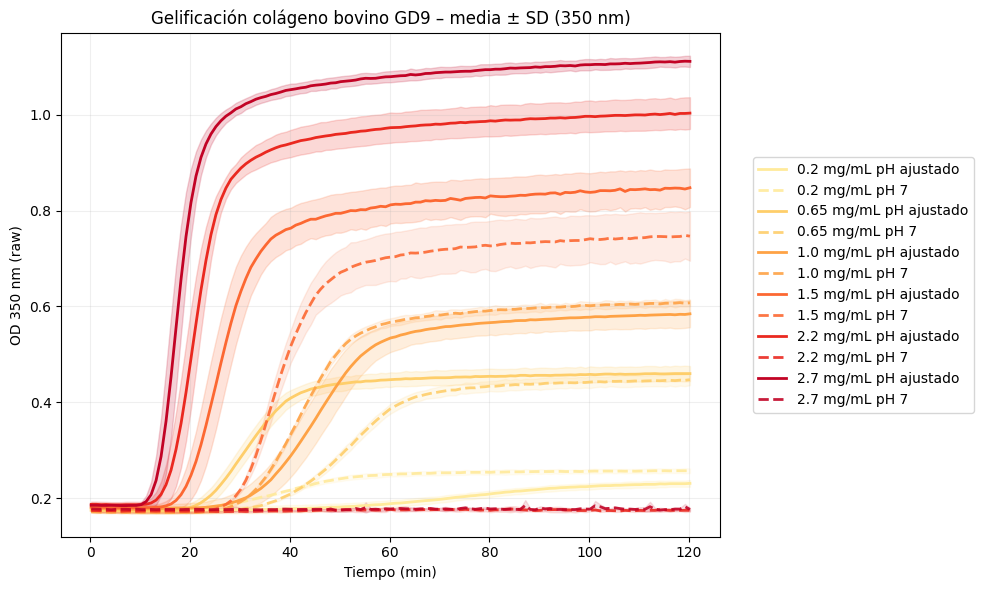

In [13]:
# Filas A–F (solo bovino), columnas 1–6
df_bov = df_long[
    (df_long["Row"].isin(["A","B","C","D","E","F"])) &
    (df_long["Col"].between(1, 6))
].copy()

# Mapa fila → concentración
conc_map = {
    "A": 0.200,
    "B": 0.650,
    "C": 1.000,
    "D": 1.500,
    "E": 2.200,
    "F": 2.700
}
df_bov["Concentration"] = df_bov["Row"].map(conc_map)
df_bov["Conc_label"] = df_bov["Concentration"].astype(str) + " mg/mL"

# pH según columna: 1–3 ajustado, 4–6 pH 7
df_bov["pH"] = np.where(df_bov["Col"].between(1,3), "pH ajustado", "pH 7")

df_bov_stats = compute_stats(df_bov)

plot_gel(df_bov_stats, "Gelificación colágeno bovino GD9 – media ± SD (350 nm)")
